BOURBON Quentin
BAYANI Anaïs

# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

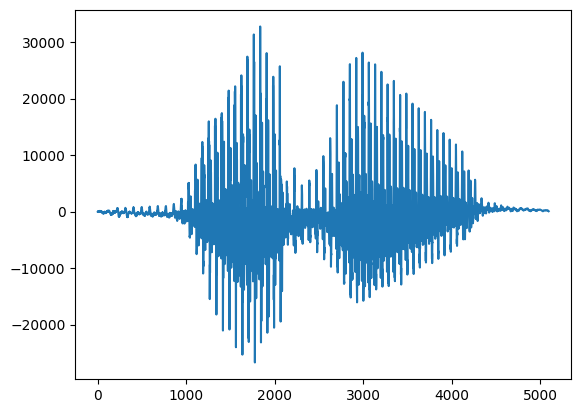

In [2]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [3]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


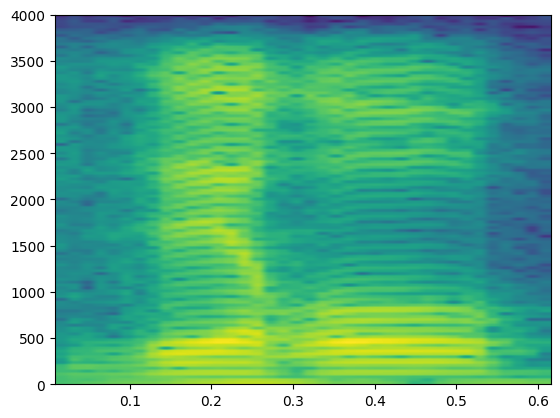

In [4]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

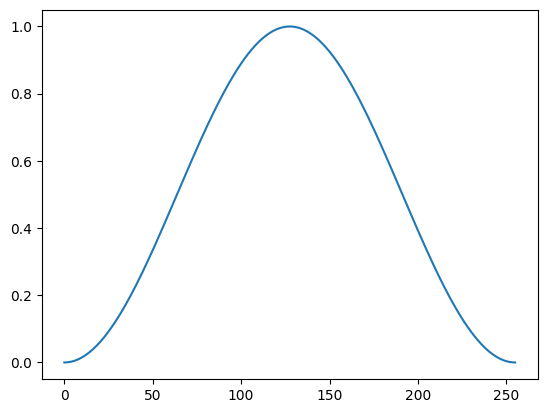

In [5]:
plt.plot(np.hanning(256))

## **Speech Feature Extraction**

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [6]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !

    cepstral_vectors = []   
    for i in range(0, len(wav_data) - window_size, window_shift):
        hann_window = np.hanning(window_size)
        pitch = wav_data[i:i+window_size] * hann_window
        pitch_log = np.log(np.abs(np.fft.fft(pitch)))
        cepstral_vectors.append(np.fft.ifft(pitch_log).real[:cepstral_order])
    
    return np.asarray(cepstral_vectors)

In [7]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
5098 // 128 - 1

38

In [9]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


Lezgo we obtain the good shape!

## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [10]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    
    n, m = len(x), len(y)
    C = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            C[i, j] = np.linalg.norm(x[i] - y[j])


    D = np.zeros((n,m))
    D[0, 0] = C[0, 0]
    for i in range(1, n):
        D[i, 0] = D[i-1, 0] + C[i, 0]
    for j in range(1, m):
        D[0, j] = D[0, j-1] + C[0, j]

    for i in range(1, min(n, m)):
        for j in range(i, n):
            D[j, i] = min(D[j-1, i-1] + gamma * C[j, i], D[j-1, i] + C[j, i], D[j, i-1] + C[j, i])
        for j in range(i+1, m):
            D[i, j] = min(D[i-1, j-1] + gamma * C[i, j], D[i-1, j] + C[i, j], D[i, j-1] + C[i, j])


    M = []
    i = n-1
    j = m-1
    while i > 0 and j > 0:
        M.append([i, j])
        mini = min(D[i-1, j-1], D[i-1, j], D[i, j-1])
        if mini == D[i-1,j-1]:
            i, j = i-1, j-1
        elif mini == D[i-1,j]:
            i -= 1
        else:
            j -= 1
    M.append([i,j])
    M.reverse()

    distance = D[-1, -1]

    return D, M, distance

In [11]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

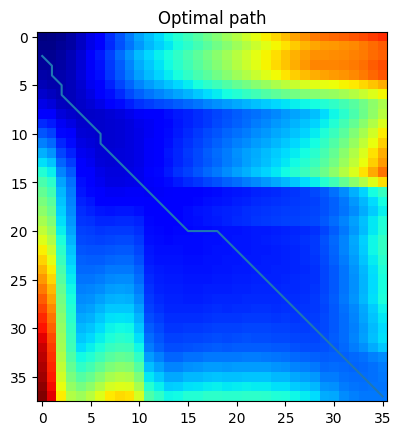

Cost of the optimal path: 24.053201219758897


In [12]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

1) 


In [21]:

for number in range(10):
    file_path_1 = f"./SIG/SIG_Rep_1_Number_{number}.wav"
    sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
    cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
    
    idx_max, idxmin = 0, 0
    dist_min, dist_max = np.inf, 0
    for i in range(2,13):
        file_path_temp = f"./SIG/SIG_Rep_{i}_Number_{number}.wav"
        sample_rate, wav_data = wavfile.read(file_path_temp)
        cepstral_vectors_temp = feature_extraction( wav_data, window_size, window_shift, cepstral_order)
        D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_temp, gamma=2)
        if distance > dist_max:
            dist_max = distance
            idx_max = i
        if distance < dist_min:
            dist_min = distance
            idx_min = i
    print(f"For the number {number}, the cost of optimal path is minimal at repetion {idx_min} ({dist_min}), and maximal at repetion {idx_max} ({dist_max})")

For the number 0, the cost of optimal path is minimal at repetion 8 (20.796606433271542), and maximal at repetion 12 (30.470442966412794)
For the number 1, the cost of optimal path is minimal at repetion 7 (14.934600382104733), and maximal at repetion 11 (34.977416682057786)
For the number 2, the cost of optimal path is minimal at repetion 7 (13.54511360818113), and maximal at repetion 10 (40.63875350501716)
For the number 3, the cost of optimal path is minimal at repetion 2 (17.619969592112298), and maximal at repetion 12 (32.937868847515034)
For the number 4, the cost of optimal path is minimal at repetion 5 (16.20061222839456), and maximal at repetion 9 (25.792781950953852)
For the number 5, the cost of optimal path is minimal at repetion 2 (20.11496219687621), and maximal at repetion 9 (28.44347494063879)
For the number 6, the cost of optimal path is minimal at repetion 2 (16.78797323766629), and maximal at repetion 9 (29.382559838001853)
For the number 7, the cost of optimal path 

Most of the cases seem to be confirmed when we listen to the audios. For example, we can hear that the 12 is a bit different (higher pitch), but other than that, the differences are too small to notice by ear.

2)


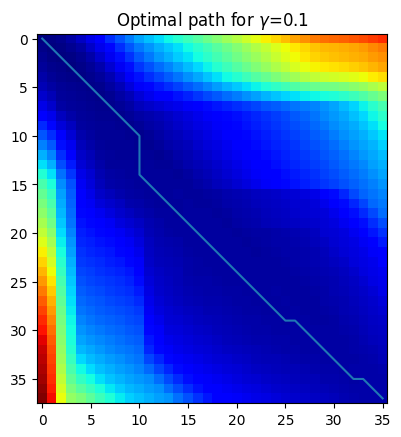

Cost of the optimal path: 4.089513787066667


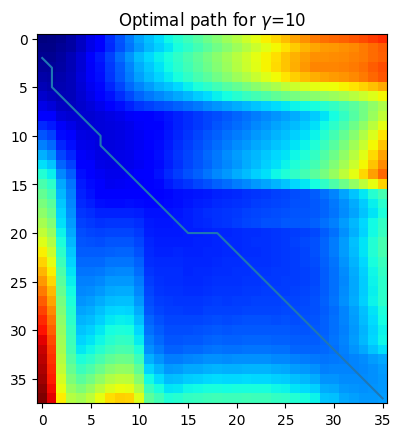

Cost of the optimal path: 27.23030151780211


In [28]:
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=0.1)
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title(r"Optimal path for $\gamma$=0.1")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=10)
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title(r"Optimal path for $\gamma$=10")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

First we can see, that gamma has a huge influence on the cost, since it went from 4 to 27 (x7). 
THe higher gamma is, the higher the weights on the diagonal path, meaning it considers that the sequences to align are similar.(more robust) 
Therefore, when gamma is small, the algorithm will be more flexible and will adapt itself more to the variations. (indeed, the cost is smaller because it follows the details more).

3)

The hypothesis is that the signal isotropic, meaning that the distance is computed the same way in all direction, and that is is meaningful to consider a small distance equivalent to a close vector.

It might not be the best way to consider the similarities between two vectors, since the vectors contain a lot of different informations (pitch, speed, intonation...).  The weighting could improve the performance, by allowing to focus on the important components of the vector.

## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix

def classification(vectors, gamma):

    #We first split the vectors in two sets
    full_idx = np.arange(len(vectors))
    reference = []
    y_ref = []
    ref_size = 0.66
    idx_ref = np.random.choice(full_idx, size=int(len(vectors)*ref_size), replace=False)
    idx_unknown = np.setdiff1d(full_idx, idx_ref)
    for idx in idx_ref:
        reference.append(vectors[idx])
        y_ref.append(idx%10)
    unknown = []
    y_true = []
    for idx in idx_unknown:
        unknown.append(vectors[idx])
        y_true.append(idx%10)

    y_pred = [] 

    for i in range(len(unknown)):
        dist_min = np.inf
        pred = None
        for j in range(len(reference)):
            D, M, distance = time_alignment(reference[j], unknown[i], gamma)
            if distance < dist_min:
                dist_min = distance
                pred = y_ref[j]
        y_pred.append(pred)

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return cm, accuracy

Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.

In [69]:
# We put everything in a vector
vectors = []
for subject_id in range(1, 13):     
    for number in range(10):
        file_path = f"./SIG/SIG_Rep_{subject_id}_Number_{number}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
vectors = np.asarray(vectors)

C:\Users\anais\AppData\Local\Temp\ipykernel_21020\2572182318.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vectors = np.asarray(vectors)


In [70]:
cm, accuracy = classification(vectors, 0.2)

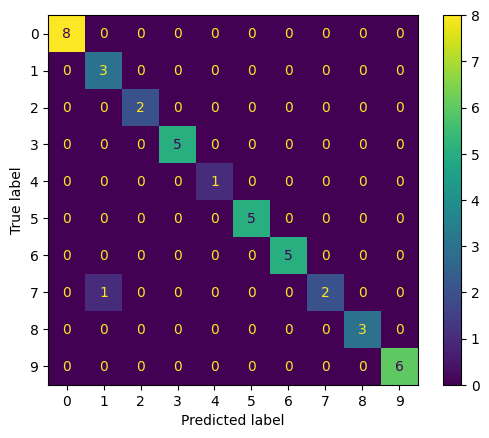

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm)
disp.plot()

C:\Users\anais\AppData\Local\Temp\ipykernel_21020\1746238830.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vectors = np.asarray(vectors)


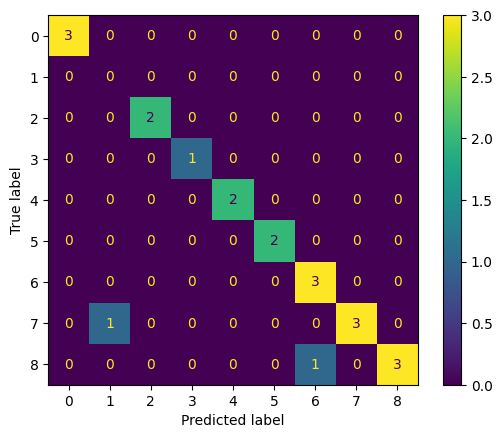

In [76]:
# We put everything in a vector
vectors = []
for subject_id in range(1, 7):     
    for number in range(10):
        file_path = f"./SIG2/SIG2_Rep_{subject_id}_Number_{number}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
vectors = np.asarray(vectors)

cm, accuracy = classification(vectors, 0.2)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

2)

C:\Users\anais\AppData\Local\Temp\ipykernel_21020\3047151220.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vectors = np.asarray(vectors)


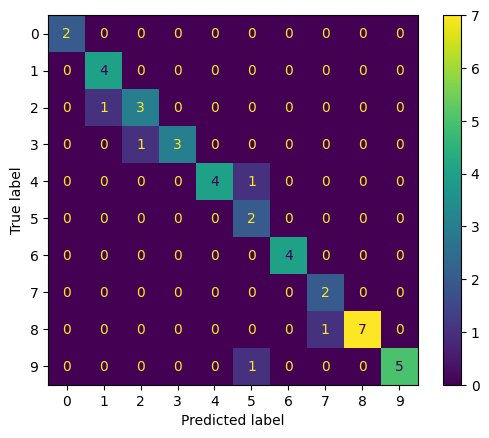

In [77]:
vectors = []
for subject_id in range(1, 13):     
    for number in range(10):
        file_path = f"./SIGMIX/SIGMIX_Rep_{subject_id}_Number_{number}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
vectors = np.asarray(vectors)

cm, accuracy = classification(vectors, 0.2)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

We observe that the results are not as good with the SIGMIX dataset, due to the high variation of the voices. It could be because the tone of the voice induces a high distance, when it is too different from the reference ones.  

3) We saw that the results were not that good when the tone of the voice is too different. We could apply beforehand an algorithm to change it accordingly. The same way, the speed influences the results, so we could transform it beforehand to adjust the speed (like we did in the previous PW).